# Travail pratique 1 - IFT 3700
##### Remis le 22 novembre 2020 par Rym Bach et Laurier Lavoie-Giasson
## Introduction
Dans le cadre de ce travail, on s'intéresse à la précision des différentes techniques de classification vues en classe, et de comparer son niveau en utilisant la distance euclidienne ainsi que [...]
## Code - chargement du jeu de données d'entraînement et de tests
### Installation des packages nécessaires

In [ ]:
import sys
!{sys.executable} -m pip install scikit-learn-extra
!{sys.executable} -m pip install tqdm scikit-image

### Chargement et prétraitement des jeux de données d'entraînement et de tests

In [2]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

CONST_N_DIM=784

def preprocessing(aX, an_dimensions=CONST_N_DIM):
    #cette fonction sera utilisée pour le prétraitement des données du jeu de données.
    
    ret_val = np.array([np.round(np.divide(aX[i], 255.0)) for i in tqdm(range(len(aX)))])
    return ret_val
    
def readMNIST(afilename, an_dimensions=CONST_N_DIM):
    #cette fonction lit le fichier de MNIST à l'emplacement fourni et retourne le jeu de
    #données sur lequel on a appliqué la fonction de prétraitement
    data = open(afilename)
    csv_file = csv.reader(data)
    data_points = [row for row in csv_file] #pour enlever les headers
    data_points.pop(0)
    #valeurs Y de taille 1 (labels)
    print("Extraction des labels pour", afilename)
    Y = np.array([int(data_points[i][0]) for i in tqdm(range(len(data_points)))])
    
    #vecteurs X de taille 784 (arrondis à l'entier le plus près)
    print("Extraction des points de données pour", afilename)
    X = np.array([[int(j) for j in data_points[i][1:]] for i in tqdm(range(len(data_points)))])
    X = X.reshape((len(Y),784))
    
    #on retourne un tuple avec les vecteurs x et les valeurs y
    return (preprocessing(X, an_dimensions),Y)

XY_train = readMNIST('mnist_train.csv', CONST_N_DIM)
X_train = XY_train[0]
Y_train = XY_train[1]

XY_test = readMNIST('mnist_test.csv', CONST_N_DIM)
X_test = XY_test[0]
Y_test = XY_test[1]

  1%|          | 305/60000 [00:00<00:19, 3041.14it/s]

Extraction des labels pour mnist_train.csv
Extraction des points de données pour mnist_train.csv


  3%|▎         | 339/10000 [00:00<00:02, 3388.43it/s]

Extraction des labels pour mnist_test.csv
Extraction des points de données pour mnist_test.csv


100%|██████████| 10000/10000 [00:00<00:00, 43109.81it/s]


### _Sanity Check_
Ici, on regarde si les données sont encore "saines", c'est à dire si on peut afficher la première lettre du jeu de données d'entraînement.

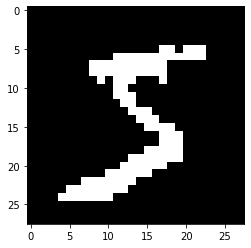

In [2]:
plt.imshow(X_train[0].reshape((28,28)), cmap="gray")
plt.show()

## Mise en place de la métrique à utiliser

### Définitions nécessaires à la métrique

Soit $X = \begin{pmatrix}x_{11} & ... & x_{1n}\\ ... & ... & ... \\ x_{n1} & ... & x_{nn}\end{pmatrix}$, l'image en question. Les moments $M_{X00}, M_{X01}$ et $M_{X10}$sont définis comme suit:
\begin{align}
    M_{Xij} = \sum_{k=1}^{d_1}\sum_{\ell}^{d_2}x_{k\ell}k^i\cdot\ell^j
\end{align}
Soit $X$ et ses moments $M_{X00}, M_{X01}$ et $M_{X10}$, on a le centroïde $\{\bar{x}_X,\bar{y}_X\} = \{\frac{M_{X10}}{M_{X00}}, \frac{M_{X01}}{M_{X00}}\}$.
Soit $X$ et son centroïde $\{\bar{x}_X,\bar{y}_X\}$, on a les moments centraux $\mu_{X00}, \mu_{X20}, \mu_{X02}, \mu_{X11}, \mu_{X30}, \mu_{X03}, \mu_{X21}$ et $\mu_{X12}$.
\begin{align}
    \mu_{Xij} = \sum_{k=1}^{d_1}\sum_{\ell=1}^{d_2}x_{k\ell}\cdot(k-\bar{x})^i\cdot(\ell−\bar{y})^j)
\end{align}
Soit $X_1 = (x_{11}, ..., x_{1n}), X_2 = (x_{21}, ..., x_{2n})$, deux vecteurs de taille $n$, on définit formellement la distance euclidienne entre ceux ci:
\begin{align}
    d_e(X_1, X_2) = \sqrt{\sum_{i=1}^n(x_{1i}-x_{2i})^2}
\end{align}

Soit $X$ et ses moments centraux, on définit $m_{vect}(X)$:
\begin{align}
    m_{vect}(X) = (\mu_{20}, \mu_{02}, \mu_{11}, \mu_{30}, \mu_{03}, \mu_{21}, \mu_{12})
\end{align}

### Définition de la métrique

Pour calculer cette distance, on calculera la similarité des points en comparant la distance euclidienne entre les vecteurs contenant leurs moments centraux $\mu_{20}, \mu_{02}, \mu_{11}, \mu_{30}, \mu_{03}, \mu_{21}$ et $\mu_{12}$.
On prendra:

On aura alors:
\begin{align}
    d_{m}(X_1, X_2) = d_{e}(m_{vect}(X_1), m_{vect}(X_2))
\end{align}

### Résistance à la translation
Pour la même raison que l'écart type et la variance $\sigma$ et $\sigma^2$ ne changent pas lorsque l'on additionne une constante $c$ à toutes les données d'une distribution, par définition, les moments centraux $\mu_{ij}$ sont invariants en translation.

##### Pour plus d'informations sur les moments, consulter les pages suivantes:
- https://en.wikipedia.org/wiki/Image_moment
- https://docs.opencv.org/master/d8/d23/classcv_1_1Moments.html

In [3]:
from skimage.measure import moments, moments_central

#fonction qui calcule les mu_ij pour un vecteur X de taille 784 donné
def compute_mu_ij(ax):
    x = ax.reshape((28,28))
    m = moments(x)
    centroid = (m[1,0]/m[0,0], m[0,1]/m[0,0])
    mu = moments_central(x, centroid)
    return np.array([mu[2,0], mu[0,2], mu[1,1], mu[3,0], mu[0,3], mu[2,1], mu[1,2]])

#on définit la fonction de similarité à utiliser
def moment_distance(ax_1, ax_2):
    return np.linalg.norm(compute_mu_ij(ax_1)-compute_mu_ij(ax_2))

## Inconvénient lors de l'utilisation de cette métrique de façon conventionnelle - Complexité
En ne faisant que spécifier la métrique dans le contructeur des différents classificateurs, on augmente drastiquement la complexité. En effet, pour les $n^2$ paires de points, pour calculer la matrice des distances entre, on effectue 1 appel de la fonction `compute_mu_ij` par point, pour un total de 2n^2. Comme la matrice est symétrique, on peut considérer que l'on appelle $n^2$ fois la fonction. Cependant, la complexité du calcul des $\mu_{ij}$ est bien plus grande que celle de la distance euclidienne! Il convient donc d'adapter notre utilisation de la méthode de calcul pour réduire la complexité.

## Solution - _precomputation_
Évidemment, une fois que l'on a exécuté compute_mu_ij pour un point du jeu de données, on peut stocker la valeur de retour dans une liste. Puisque la métrique proposée utilise la distance euclidienne à l'intérieur, on peut donc simplement faire un précalcul des $\mu_{ij}$ nécessaires pour la métrique, et les stocker dans une liste. Cela nous permettra de classifier le jeu de données de la même façon que l'on l'aurait fait dans le jeu de données d'origine.

Par contre, pour pouvoir classer une donnée, on devra d'abord effectuer la transformation pour obtenir les $\mu_{ij}$.

La cellule ci-dessous effectue le précalcul nécessaire à la métrique.

## Implémentation particulière

Une autre solution aurait été d'utiliser la fonctionnalité "precomputed" de Scikit-learn, en combinaison avec la méthode `sklearn.metrics.pairwise_distances`. Cependant, générer une telle matrice prend **beaucoup de temps de calcul, et consomme beaucoup de mémoire**. Pour cette raison, il convient d'instancier un modèle basé entièrement sur les vecteurs des $\mu_{ij}$. Avant la classification, il suffira de convertir une donnée en son vecteur de moments en utilisant la fonction `compute_mu_ij`, et de classifier le résultat; un exemple suivra pour le démontrer.

In [4]:
def precompute_mu_ij_matrix(aX):
    return np.array([compute_mu_ij(x) for x in tqdm(aX)])

print("précalcul des mu_ij pour le jeu de données d'entraînement")
X_train_mu = precompute_mu_ij_matrix(X_train)
print("précalcul des mu_ij pour le jeu de données de tests")
X_test_mu = precompute_mu_ij_matrix(X_test)

  1%|          | 398/60000 [00:00<00:15, 3973.31it/s]

précalcul des mu_ij pour le jeu de données d'entraînement


  5%|▍         | 488/10000 [00:00<00:01, 4877.50it/s]

précalcul des mu_ij pour le jeu de données de tests


100%|██████████| 10000/10000 [00:01<00:00, 5064.33it/s]


## Exemple de classification d'un point de données en utilisant la distance des moments

Prédiction: 7


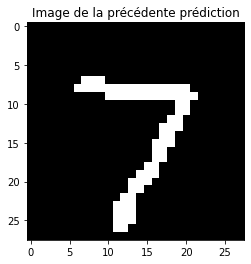

Prédiction: 2


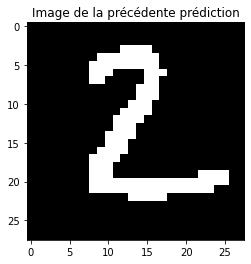

Prédiction: 1


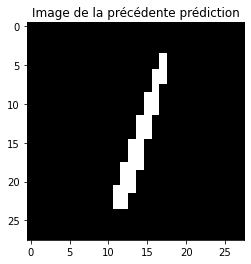

Prédiction: 0


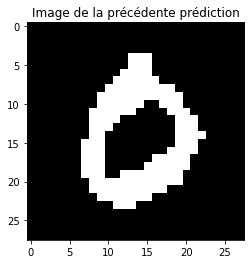

Prédiction: 4


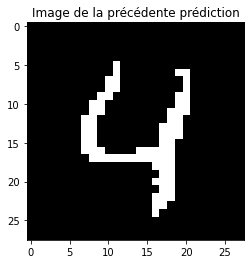

Prédiction: 1


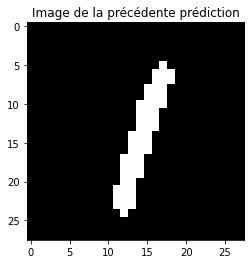

Prédiction: 4


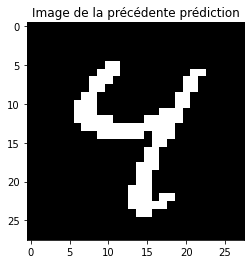

Prédiction: 9


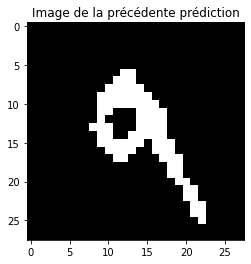

Prédiction: 4


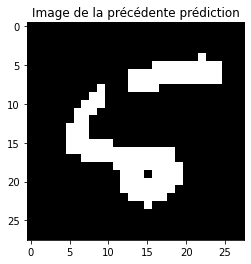

Prédiction: 7


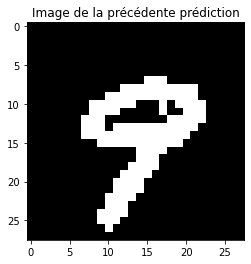

Prédiction: 0


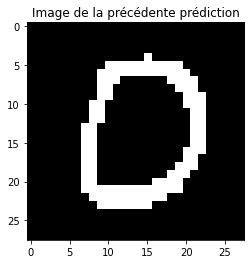

Prédiction: 6


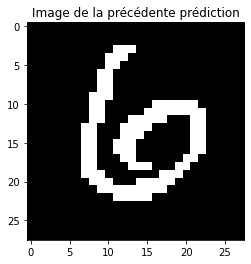

Prédiction: 9


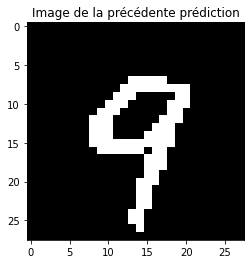

Prédiction: 0


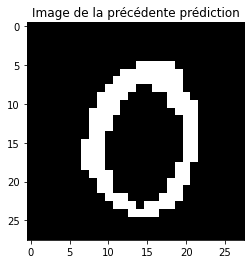

Prédiction: 1


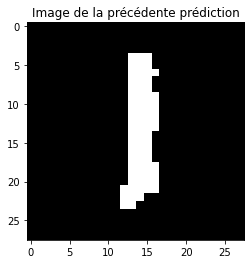

In [5]:
from sklearn.neighbors import KNeighborsClassifier


def classify_etaij(data_point):
    
    classifier = KNeighborsClassifier(n_neighbors=4)
    classifier.fit(X_train_mu, Y_train)

    #on sélectionne une donnée
    x_to_classify=data_point
    #on applique la transformation
    mu_x = compute_mu_ij(x_to_classify)
    #on classifie le résultat
    print(f"Prédiction: {classifier.predict(np.array([mu_x]))[0]}")

    #vérification additionnelle
    plt.title("Image de la précédente prédiction")
    plt.imshow(data_point.reshape((28,28)), cmap="gray")
    plt.show()

for i in range(15):
    classify_etaij(X_test[i])

## À première vue: une métrique efficace ?

On voit que pour les 15 premiers exemplaires, la méthode des $k$ plus proches voisins fonctionne relativement bien en utilisant la métrique proposée, la _distance des moments_. Nous allons voir que cette mesure de similarité permet d'obtenir des résultats tout de même très satisfaisants, tout en bénéficiant d'un temps de calcul réduit.

### Temps de calcul avantageux
Effectivement, on a pu voir dans la cellule précédente qu'après le précalcul des $\mu_{ij}$, l'utilisation de la métrique de la manière proposée permet l'entraînement d'un classificateur à une vitesse extrêmement rapideme. Ce n'est en aucun cas comparable à l'entraînement d'un classificateur en utilisant la distance euclidienne seule.

## Un regard plus détaillé sur la performance de cette métrique 

Il convient maintenant de comparer la performance de la métrique en utilisant divers algorithmes de classification et de réduction de dimensionnalité. On verra que, bien qu'à première vue cette métrique semble efficace, sa performance n'est pastout à fait aussi bonne que celle de la distance euclidienne.

### Méthode des K plus proches voisins

Ici, pour accélérer le temps de calcul, on utilise le module `multiprocessing`. On démarre des processus pour ne pas être limité par le _Global Interpreter Lock_ de Python.

In [6]:
from multiprocessing import Process
from multiprocessing.sharedctypes import Array
from sklearn.neighbors import KNeighborsClassifier
import math
#on va utiliser ici du multi-processing pour travailler autour du GIL de Python,
#on va démarrer plusieurs processus et travailler sur des variables partagées

def fit_and_score(aX_train, aY_train, aX_test, aY_test, ak, aAccuracy_shared_array):
    classifier = KNeighborsClassifier(n_neighbors=ak)
    classifier.fit(aX_train, aY_train)
    aAccuracy_shared_array[ak] = classifier.score(aX_test, aY_test)
    return aAccuracy_shared_array[ak]

def classify_KNN(aX_train, aY_train, aX_test, aY_test, max_neighbors, multi_process=True):
    if multi_process:
        #on crée un tableau partagé de doubles "primitifs" de C pour les résultats
        aX_train_shared=Array('d', aX_train.shape[0]*aX_train.shape[1])
        #on le passe à Numpy pour utilisation à travers l'interface "buffer"
        aX_train_mp=np.frombuffer(aX_train_shared.get_obj()).reshape(aX_train.shape)
        #on copie les valeurs de l'argument dans le tableau partagé
        np.copyto(aX_train_mp, aX_train)
        
        aY_train_shared=Array('d', aY_train.size)
        aY_train_mp=np.frombuffer(aY_train_shared.get_obj())
        np.copyto(aY_train_mp, aY_train)
        
        
        aX_test_shared=Array('d', aX_test.shape[0]*aX_test.shape[1])
        aX_test_mp=np.frombuffer(aX_test_shared.get_obj()).reshape(aX_test.shape)
        np.copyto(aX_test_mp, aX_test)
        
        
        aY_test_shared=Array('d', aY_test.size)
        aY_test_mp=np.frombuffer(aY_test_shared.get_obj())
        np.copyto(aY_test_mp, aY_test)
        
        #initialisation des K impairs
        k_range = range(max_neighbors)
        
        #on crée un tableau partagé de doubles "primitifs" de C pour stocker la précision des modèles
        accuracy_array = Array('d', len(k_range))
        accuracy = np.frombuffer(accuracy_array.get_obj())
        #on initialise les valeurs à zéro
        np.copyto(accuracy, np.zeros(len(k_range)))
        
        processes = []
        
        for k in k_range:
            if k % 2 != 0:
                #spawn un processus pour calculer, qui lira la mémoire partagée
                myprocess=Process(target=fit_and_score, args=(aX_train_mp, aY_train_mp, aX_test_mp, aY_test_mp, k, accuracy))
                processes.append(myprocess)
                myprocess.start()
        for i in tqdm(range(len(processes))):
            myprocess=processes[i]
            #join le processus pour arrêter l'exécution jusqu'à temps que les calculs soient terminés
            myprocess.join()
            del myprocess
        #retourner les paires de K et de précision
        return np.array([np.array(k_range), accuracy])
    else:
        for k in tqdm(range(max_neighbors)):
            if k % 2 != 0:
                classifier = KNeighborsClassifier(n_neighbors=1)
                classifier.fit(aX_train, aY_train)
                print(classifier.score(aX_test, aY_test))

def plot_KNN_results(adist_name, ak_and_acc_vects):
    filtered_results = [[],[]]
    for i in range(len(ak_and_acc_vects[0])):
        if i % 2 == 1:
            filtered_results[0].append(ak_and_acc_vects[0][i])
            filtered_results[1].append(ak_and_acc_vects[1][i])
            
    filtered_results = np.array(filtered_results)
    
    max_acc_idx = np.argmax(filtered_results[1])
    max_acc_K = int(filtered_results[0][max_acc_idx])
    max_acc = filtered_results[1][max_acc_idx]
    print(f"K optimal: {max_acc_idx}")
    print(f"Précision optimale ({adist_name}): {max_acc}")

    plt.plot(filtered_results[0], filtered_results[1])
    plt.xlabel('k')
    plt.ylabel('Précision')
    plt.title(f'Précision de la Classification en Fonction de k ({adist_name})')
    plt.show()
    return max_acc

In [23]:
resultats_KNN = classify_KNN(X_train, Y_train, X_test, Y_test, 15, True)
acc_euc = plot_KNN_results("Distance Euclidienne", resultats_KNN)

  0%|          | 0/7 [00:07<?, ?it/s]


KeyboardInterrupt: 

On voit ici que la précision est la plus haute lorsque $k = 1$. Pour des raisons de temps de calcul, on n'a pas testé l'algorithme à plus que 12 voisins, puisque de toute manière, la précision diminuait au fur et à mesure que l'on augmentait $k$.

100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


K optimal: 4
Précision optimale (Distance des Moments): 0.7804


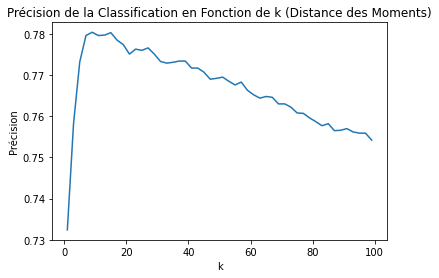

In [7]:
resultats_KNN_moments = classify_KNN(X_train_mu, Y_train, X_test_mu, Y_test, 100, True)
acc_mom = plot_KNN_results("Distance des Moments", resultats_KNN_moments)

On voit ici qu'en utilisant notre métrique, la distance des moments, la précision est la plus haute lorsque $k = 13$. Puisque la classification se fait beaucoup plus rapidement lorsqu'on utilise cette métrique, on a même pu effectuer les itérations jusqu'à trouver les 100 plus proches voisins.
### Analyse (KNN)
On voit clairement que la précision est beaucoup moins bonne que la distance euclidienne. Cependant, même avec le précalcul nécessaire à l'utilisation de la métrique, le temps de calcul a considérablement diminué. Il existe potentiellement des situations où l'on bénéficierait d'une telle accélération, même au coût d'une perte de précision.

### Classification à l'aide d'un arbre décisionnel

In [8]:
from sklearn.tree import DecisionTreeClassifier
import math

def classify_dt(aX_train, aY_train, aX_test, aY_test):
    classifier = DecisionTreeClassifier()#criterion='entropy')
    classifier.fit(aX_train, aY_train)
    return classifier.score(aX_test, aY_test)

acc_euc = classify_dt(X_train, Y_train, X_test, Y_test)
acc_mom = classify_dt(X_train_mu, Y_train, X_test_mu, Y_test)
print(f"Précision de l'arbre décisionnel en utilisant la Distance Euclidienne: {acc_euc}")
print(f"Précision de l'arbre décisionnel en utilisant la Distance des Moments: {acc_mom}")
print(f"Précision relative de la métrique en utilisant un arbre décisionnel: {acc_mom/acc_euc}")

Précision de l'arbre décisionnel en utilisant la Distance Euclidienne: 0.8657
Précision de l'arbre décisionnel en utilisant la Distance des Moments: 0.7123
Précision relative de la métrique en utilisant un arbre décisionnel: 0.8228023564745293


### Analyse (Arbre décisionnel)
Évidemment, la précision n'est pas aussi élevée. C'est à s'y attendre; on a réduit notre espace vectoriel de $\mathbb{R}^{784}$ à $\mathbb{R}^{7}$, donc on perd de la granularité lors de l'analyse statistique des données.

###### Il serait incorrect d'affirmer que le gain de performance est assez significatif pour justifier cette perte de précision; le temps de calcul était court en utilisant la distance euclidienne, même sur le jeu de données entier. Pour cette raison, l'utilisation de cette métrique est déconseillée dans le contexte d'un darbre décisionnel.

### Réduction de dimensionalité à l'aide de MDS (PCoA)

In [38]:
#from sklearn.manifold import MDS
#from sklearn.metrics import pairwise_distances
#from sklearn.neighbors import KNeighborsClassifier

#distance_matrix_euc= pairwise_distances(X_train[:3000])

#model = MDS(n_components=10, dissimilarity='precomputed')
#out_euc = model.fit_transform(distance_matrix_euc)

#classifier = KNeighborsClassifier(n_neighbors=3)
#classifier.fit(out_euc, Y_train[:3000])
#print(f"Précision de la classification en utilisant KNN {classifier.score(out_euc, Y_test)}")

distance_matrix_mom = pairwise_distances(X_train_mu[:3000])
out_mom = model.transform(distance_matrix_mom)
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit_transform(out_mom, Y_train[:3000])
print(f"Précision de la classification en utilisant KNN {classifier.score(out_mom, Y_test)}")

AttributeError: 'MDS' object has no attribute 'transform'

### _Classifcateur Bonus - Perceptron multi-couches (CNN)_
Évidemment, on n'appliquera pas ce classificateur sur le jeu de données dans son entièreté. Cependant, il est intéressant de remarquer que l'on peut obtenir une précision de 90% en utilisant seulement 3000 données sur les 60000 disponibles dans le jeu de données.

Aussi, il serait évidemment possible de configurer les hyperparamètres de différentes manières, ce qui pourrait potentiellement utiliser , mais les hyperparamètres sélectionnés, coïncidemment, donnaient les résultats les plus raisonnables dans les deux cas.

In [9]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(solver='adam',
                    alpha=1e-5,
                    hidden_layer_sizes=(200),
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    max_iter=200,
                    random_state=4)

classifier.fit(X_train[:3000], Y_train[:3000])
acc_euc = classifier.score(X_test, Y_test)
#delta_t_euc = t2-t1
#print(f"Temps de calcul pour faire converger le Perceptron multicouches en utilisant la distance euclidienne:{delta_t_euc}")
print(f"Précision du Perceptron en utilisant la distance euclidienne sur 5% du jeu de données: {acc_euc}")

classifier = MLPClassifier(solver='adam',
                    alpha=1e-5,
                    hidden_layer_sizes=(200),
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    max_iter=200,
                    random_state=7)
#ici, on peut entraîner le modèle sur tout le jeu de données, et ce, bien plus rapidement qu'en utilisant la distance
#euclidienne sur seulement 5% du jeu de données !
classifier.fit(X_train_mu, Y_train)
acc_mom = classifier.score(X_test_mu, Y_test)
print(f"Précision du Perceptron en utilisant la distance des moments sur tout le jeu de données: {acc_mom}")
print(f"Précision relative de la métrique en utilisant un perceptron multi-couches:{acc_mom/acc_euc}")

Précision du Perceptron en utilisant la distance euclidienne sur 5% du jeu de données: 0.911
Précision du Perceptron en utilisant la distance des moments sur tout le jeu de données: 0.7927
Précision relative de la métrique en utilisant un perceptron multi-couches:0.8701427003293084


### Analyse - Perceptron multi-couches

Clairement, on pourrait argumenter qu'il nest pas convenable de comparer la précision d'un algorithme entrainé sur 60000 données. Cependant, **c'est là la force de la métrique: il a été possible d'entraîner un modèle plus rapidement, en conservant plus de 80% de la précision d'un modèle qui, même en utilisant moins de points de données, prend plusieurs dizaines de minutes à entraîner**.

On peut imaginer que, dans l'ère de l'information dans laquelle nous vivons, il existera assurément des situations où la performance de l'analyse des données sera d'une grande importance.

**On peut naturellement penser à un système embarqué pour lequel les ressources matérielles sont limitées mais où l'on doit traiter beaucoup de points de données en temps réel.**

### Classification en utilisant l'algorithme K-médoïdes


L'algorithme des k-médoïdes est un algorithme de partitionnement plus robuste vis-à-vis des données aberrantes que celui des k-moyennes. L'algorithme des k-médoïdes minimise l'erreur quadratique moyenne qui est la distance entre les points de la classe et le point central, qui est un point du jeu de données. On va donc l'appliquer sur nos données 

In [10]:
from multiprocessing import Process
from multiprocessing.sharedctypes import Array
#from sklearn_extra.cluster import KMedoids
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import math

def fit_and_silhouette(aX_train, aY_train, aX_test, aY_test, ak):
    #classifier = KMedoids(n_clusters=ak, max_iter=10000)
    classifier = KMedoids(n_clusters=ak, max_iter=100000)
    y_predicted = classifier.fit_predict(aX_train)
    return silhouette_score(aX_train, y_predicted)

def fit_and_score(aX_train, aY_train, aX_test, aY_test, ak):
    classifier = KMedoids(n_clusters=ak, max_iter=1000)
    classifier.fit(aX_train)
    test_predicted = classifier.predict(aX_test)
    medoids_indices = classifier.medoid_indices_
    #calcul de la précision
    acc = np.mean(np.array([1 if aY_train[medoids_indices[test_predicted[i]]] == aY_test[i] else 0 for i in range(len(aY_test))]))
    return acc

def classify_KMedoids(aX_train, aY_train, aX_test, aY_test, amin_k, amax_k):
    k_range = range(amin_k, amax_k+1)
    k_range_np = np.array(k_range)
    silhouette_scores = [fit_and_silhouette(aX_train, aY_train, aX_test, aY_test, k) for k in k_range]
    return np.array([k_range_np, silhouette_scores])

def plot_KMedoids_results(aresults, ametric_name):
    max_silh_idx = np.argmax(aresults[1])
    max_silh_k = int(aresults[0][max_silh_idx])

    print(f"K avec le meilleur score silhouette ({ametric_name}): {max_silh_k}")

    plt.plot(aresults[0], aresults[1])
    plt.xlabel('k')
    plt.ylabel('Score silhouette')
    plt.title('Score silhouette en fonction de k (distance euclidienne)');
    plt.show()
    return max_silh_k

In [15]:
resultats_KMedoids = classify_KMedoids(X_train[:3000], Y_train[:3000], X_test, Y_test, 10, 40)

max_silh_k = plot_KMedoids_results(resultats_KMedoids, "distance euclidienne")

print(f"Précision de la classification en utilisant le K optimal pour la distance euclidienne: {fit_and_score(X_train[:3000], Y_train[:3000], X_test, Y_test, max_silh_k)}")

NameError: name 'classify_KMedoids' is not defined

In [ ]:
resultats_KMedoids_moments = classify_KMedoids(X_train_etaij[:3000], Y_train[:3000], X_test_etaij, Y_test, 10, 40)

max_silh_k = plot_KMedoids_results(resultats_KMedoids, "distance des moments")
http://localhost:8888/notebooks/Documents/cours/IFT3700/Travail%201/Travail1.ipynb#
print(f"Précision de la classification en utilisant le K optimal pour la distance des moments: {fit_and_score(X_train[:3000], Y_train[:3000], X_test, Y_test, max_silh_k)}")

### Visualisation de la répartition des données à l'aide de Isomap
On va ici répartir les données en les transformant à l'aide de Isomap, en les faisant passer en 2 dimensions

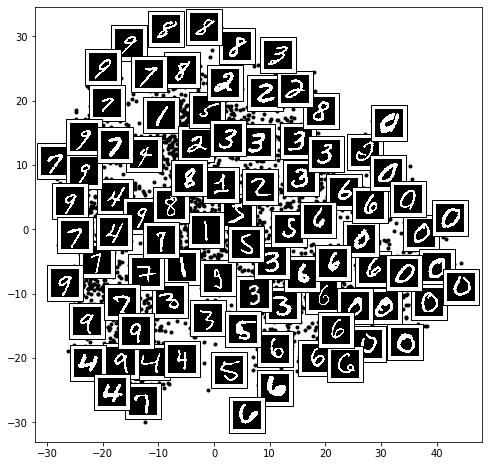

In [30]:
from matplotlib import offsetbox
from sklearn.manifold import Isomap 



def plot_components(data, model, images=None, ax=None, thumb_frac=0.07, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2 
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1) 
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue

            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                                  proj[i])
            ax.add_artist(imagebox)

reshaped_X = np.array([X_train[i].reshape(28,28) for i in range(len(X_train))])
fig, ax = plt.subplots(figsize=(8, 8))
plot_components(X_train[:3000],model=Isomap(n_components=2),images=reshaped_X[:, :, :])

On peut voir que les images qui semblent visiblement faire partie de la même classe (c'est-à dire les données que le lecteur peut identifier comme faisant partie de la même classe) sont regroupées ensemble dans le plan en 2D généré.

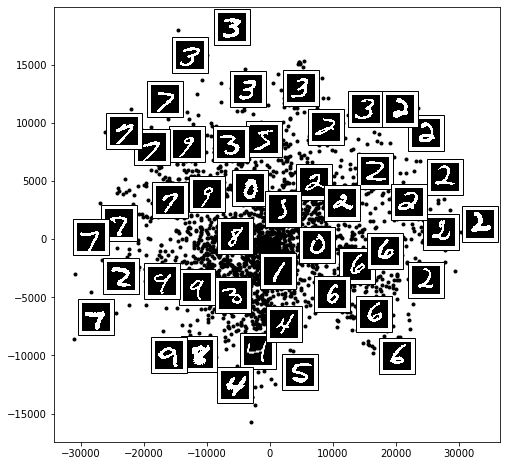

In [28]:
reshaped_X = np.array([X_train[i].reshape(28,28) for i in range(len(X_train))])
fig, ax = plt.subplots(figsize=(8, 8))
plot_components(X_train_mu[:3000],model=Isomap(n_components=2),images=reshaped_X[:, :, :])

On peut voir que, comme 

### Analyse (PCoA)


In [1]:
from loaders import Mnist
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

x, y = Mnist().train
def show_mnist(vec, vmin=None, vmax=None):
    plt.imshow(vec.reshape(28,28), cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.show()
    
def Classify_PCoA(X_train, Y_train):
    cov = np.cov(X_train.T)
    c, v = np.linalg.eigh(cov)
    w = np.linalg.inv(v)
    return v[:,-Y_train:], w[-Y_train:]


    
def PCoA_distance_edi () :             
    
    MatrixSimi = pCoA.fit(Y_train)
    edition_PCoA = MDS(dissimilarity='precomputed')
    positions_custom = edition_PcoA.fit(MatrixSimi)
    positions_c = positions_custom.embedding_
    fig = plt.figure(1)
    plt.scatter(positions_c[:, 0], positions_c[:, 1], color='darkorange', s=5, label='Distance Edition Personalisée')
    plt.show()
    
def PCoA_Euclidienne () :             
    
    MatrixDeucli = euclidean_distances(X_train)
    pCoA = MDS(dissimilarity='precomputed')
    euclidean_p = pCoA.fit(Y_train)
    positions_e = euclidean_p.embedding_
    fig = plt.figure(4)
    plt.scatter(positions_e[:, 1], positions_e[:, 3], color='gris', s=5, label='Distance Euclidienne')
    plt.show()
    fig = plt.figure(1)

    
    
def PCoA_Euclidienne2 () :             
    
    MatrixDeucli = euclidean_distances(X_train)
    mds_euclidean = MDS()
    position_PcoA_euclidiean= mds_euclidean.fit( MatrixDeucli )
    position_e_PcoA = position_PcoA_euclidiean.embedding_
    fig = plt.figure(5)
    plt.scatter(position_e_mds[:, 0], position_e_mds[:, 1], color='blue', s=5, label='Distance Euclidienne MDS')
    plt.show()


ModuleNotFoundError: No module named 'loaders'